In [45]:
import sys
import os

path = os.path.join('..', '/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))

In [46]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import pickle as pkl

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn.models import GAT
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import MDAnalysis
from MDAnalysis.analysis.distances import distance_array

import networkx as nx

from tqdm import tqdm

import sbmlcore
import sbmlsim

import wandb

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [47]:
model = torch.load('saved_models/18_node_feats-Run_8-1500_epochs/F1=0.816_epoch=1233.pth', map_location=torch.device('cpu'))

/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_49863/2760178502.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('saved_models/18_node_feat

In [48]:
model

GCN(
  (conv1): GraphConv(18, 240)
  (conv2): GraphConv(240, 240)
  (conv3): GraphConv(240, 240)
  (lin): Linear(in_features=240, out_features=2, bias=True)
  (batchnorm1): BatchNorm(240)
  (batchnorm2): BatchNorm(240)
)

In [49]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 241202
Trainable parameters: 241202


In [50]:
with open('datasets/x18_exp_l2_graph_dict.pkl', 'rb') as f:
    dataset = pkl.load(f)

In [51]:
test_list = [dataset['test'][i]['graph'].dataset[0] for i in dataset['test'].keys()]

In [52]:
test_list

[Data(x=[185, 18], edge_index=[2, 5484], edge_attr=[5484, 1], y=1),
 Data(x=[185, 18], edge_index=[2, 5464], edge_attr=[5464, 1], y=0),
 Data(x=[185, 18], edge_index=[2, 5434], edge_attr=[5434, 1], y=1),
 Data(x=[185, 18], edge_index=[2, 5470], edge_attr=[5470, 1], y=0),
 Data(x=[185, 18], edge_index=[2, 5478], edge_attr=[5478, 1], y=0),
 Data(x=[185, 18], edge_index=[2, 5480], edge_attr=[5480, 1], y=0),
 Data(x=[185, 18], edge_index=[2, 5470], edge_attr=[5470, 1], y=1),
 Data(x=[185, 18], edge_index=[2, 5458], edge_attr=[5458, 1], y=1),
 Data(x=[185, 18], edge_index=[2, 5470], edge_attr=[5470, 1], y=0),
 Data(x=[185, 18], edge_index=[2, 5456], edge_attr=[5456, 1], y=1),
 Data(x=[185, 18], edge_index=[2, 5476], edge_attr=[5476, 1], y=0),
 Data(x=[185, 18], edge_index=[2, 5488], edge_attr=[5488, 1], y=0),
 Data(x=[185, 18], edge_index=[2, 5488], edge_attr=[5488, 1], y=0),
 Data(x=[185, 18], edge_index=[2, 5470], edge_attr=[5470, 1], y=0),
 Data(x=[185, 18], edge_index=[2, 5484], edge_at

In [53]:
from torch_geometric.explain import GNNExplainer, Explainer, Explanation

# Create the explainer
# torch.cuda.manual_seed_all(12345)
# np.random.seed(12345)

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    node_mask_type='common_attributes', # "common_attributes" masks each feature across all nodes
    edge_mask_type='object', #  "object" masks each edge
    model_config={"mode":"binary_classification", 
                  'task_level': 'graph', 
                  'return_type': 'raw'}
)

node_feature_masks = torch.Tensor([])
edge_masks = []

# Iterate through each allele in the dataset
for allele in tqdm(test_list):
    # Explain the prediction for a specific graph in the dataset
    explanation = explainer(allele.x, allele.edge_index, edge_weight = allele.edge_attr, batch = None)
    node_feature_masks = torch.cat((node_feature_masks, explanation.node_mask), dim=0)
    # edge_masks = torch.cat((edge_masks, explanation.edge_mask.unsqueeze(0)), dim=0)
    edge_masks.append(explanation.edge_mask)
    
    

# # Print the feature importance
# print("Node feature importance:")
# print(explanation.node_mask)

# # Print the edge importance
# print("Edge importance:")
# print(explanation.edge_mask)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [02:42<00:00,  1.23it/s]


In [54]:
from collections import defaultdict

edge_importance_dict = defaultdict(list)

for graph, edge_mask in zip(test_list, edge_masks):
    for edge, edge_importance in zip(graph.edge_index.t(), edge_mask):
        edge = tuple(edge.tolist()) 
        edge_importance_dict[edge].append(edge_importance.item())


In [55]:
avg_edge_importance = {edge: np.mean(importances) for edge, importances in edge_importance_dict.items()}

In [56]:
edge_importance_df = pd.DataFrame(list(avg_edge_importance.items()), columns=['Edge', 'Importance'])

In [57]:
# edge_importance_df.to_csv('../data/edge_importance_df.csv', index=False)

In [58]:
edge_importance_df.sort_values(by='Importance', ascending=False).describe()

,Importance
count,6256.000000
mean,0.276720
std,0.009499
min,0.000000
25%,0.275890
50%,0.277121
75%,0.278394
max,0.331629


In [59]:
print(np.percentile(edge_importance_df['Importance'], 1), np.percentile(edge_importance_df['Importance'], 99))

0.25070239380002024 0.29840326681733126


/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_49863/297003181.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.27660456657409666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix.at[y, x] = row['Importance']
/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_49863/297003181.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2781959395110607' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix.at[y, x] = row['Importance']
/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_49863/297003181.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2766763004660606' has dtype incompatible with int64, please explicitly cas

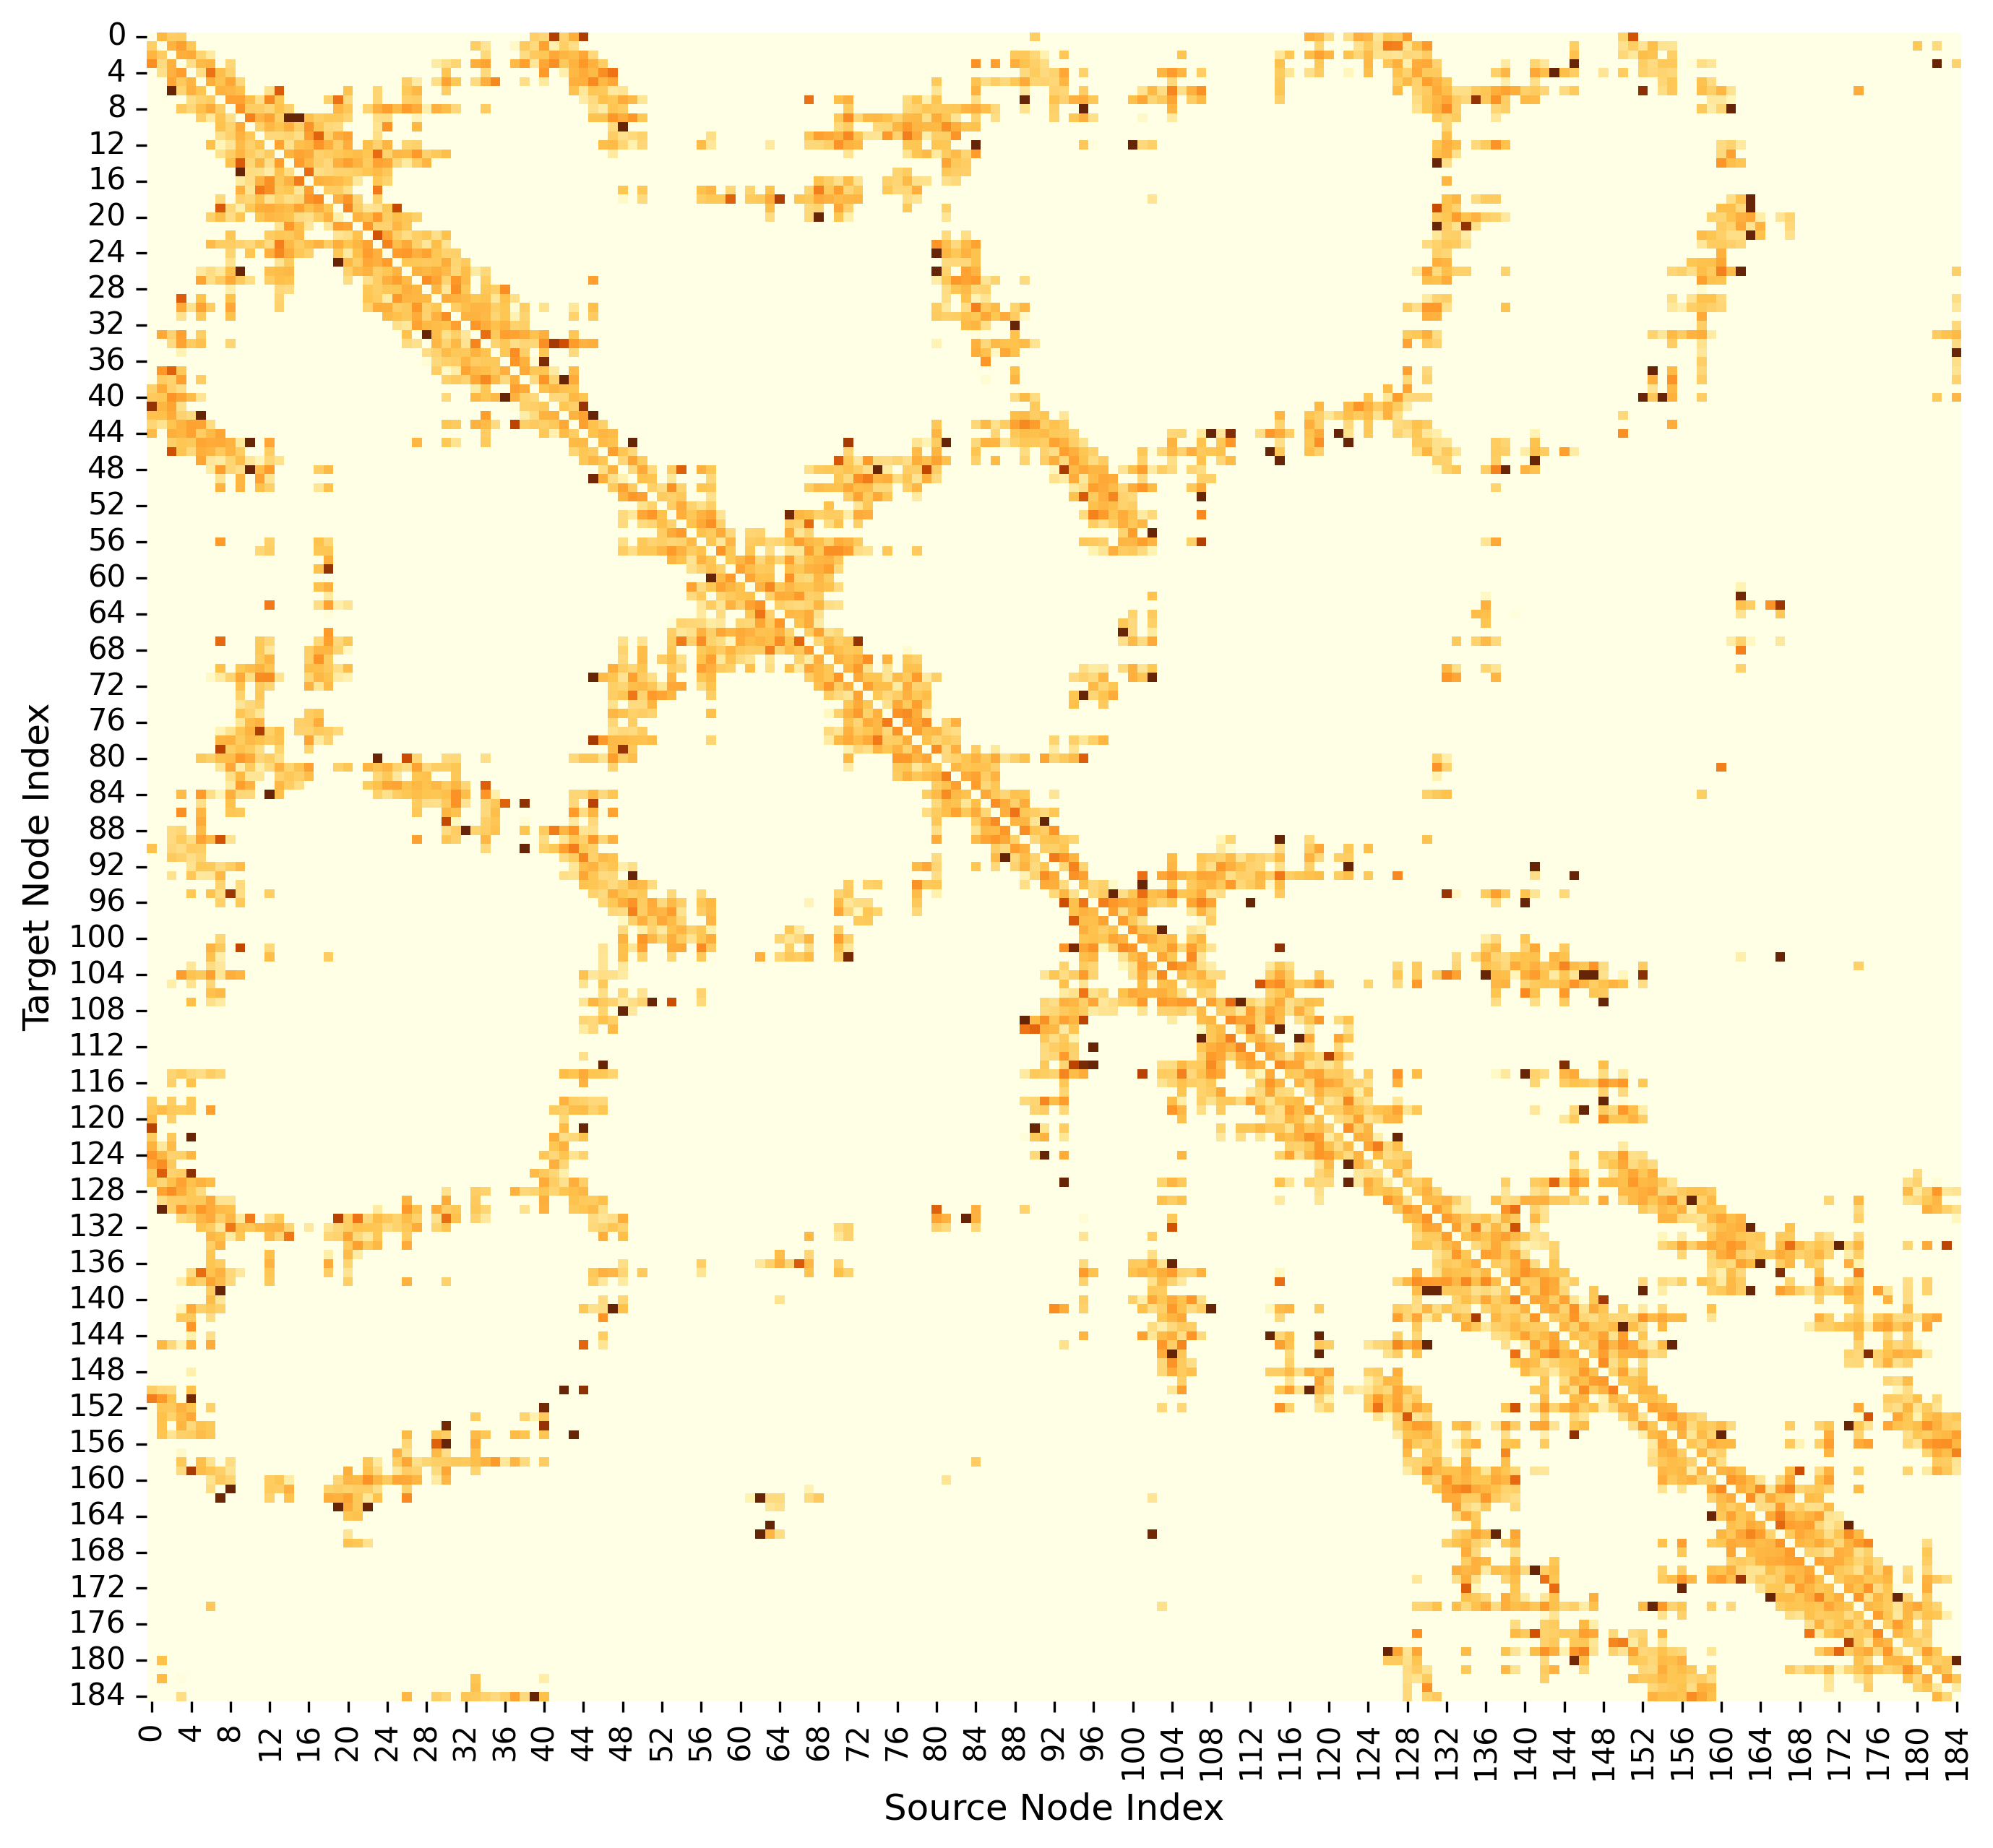

In [60]:
import seaborn as sns

# Create a matrix with Edge[0] as x and Edge[1] as y
matrix = pd.DataFrame(
    0, 
    index=sorted(set([e[1] for e in edge_importance_df['Edge']])), 
    columns=sorted(set([e[0] for e in edge_importance_df['Edge']]))
)
for idx, row in edge_importance_df.iterrows():
    x, y = row['Edge']
    matrix.at[y, x] = row['Importance']

plt.figure(figsize=(12*0.9, 10))
sns.heatmap(matrix, cmap='YlOrBr', 
            # yticklabels=True,
            vmin=0.27,
            vmax=0.29
            # vmin=0.251645128056407,
            # vmax=0.31862681806087495
            )
plt.gca().collections[0].colorbar.remove()
plt.xlabel('Source Node Index')
plt.ylabel('Target Node Index')
# # plt.title('Edge Importance Heatmap')
plt.show()

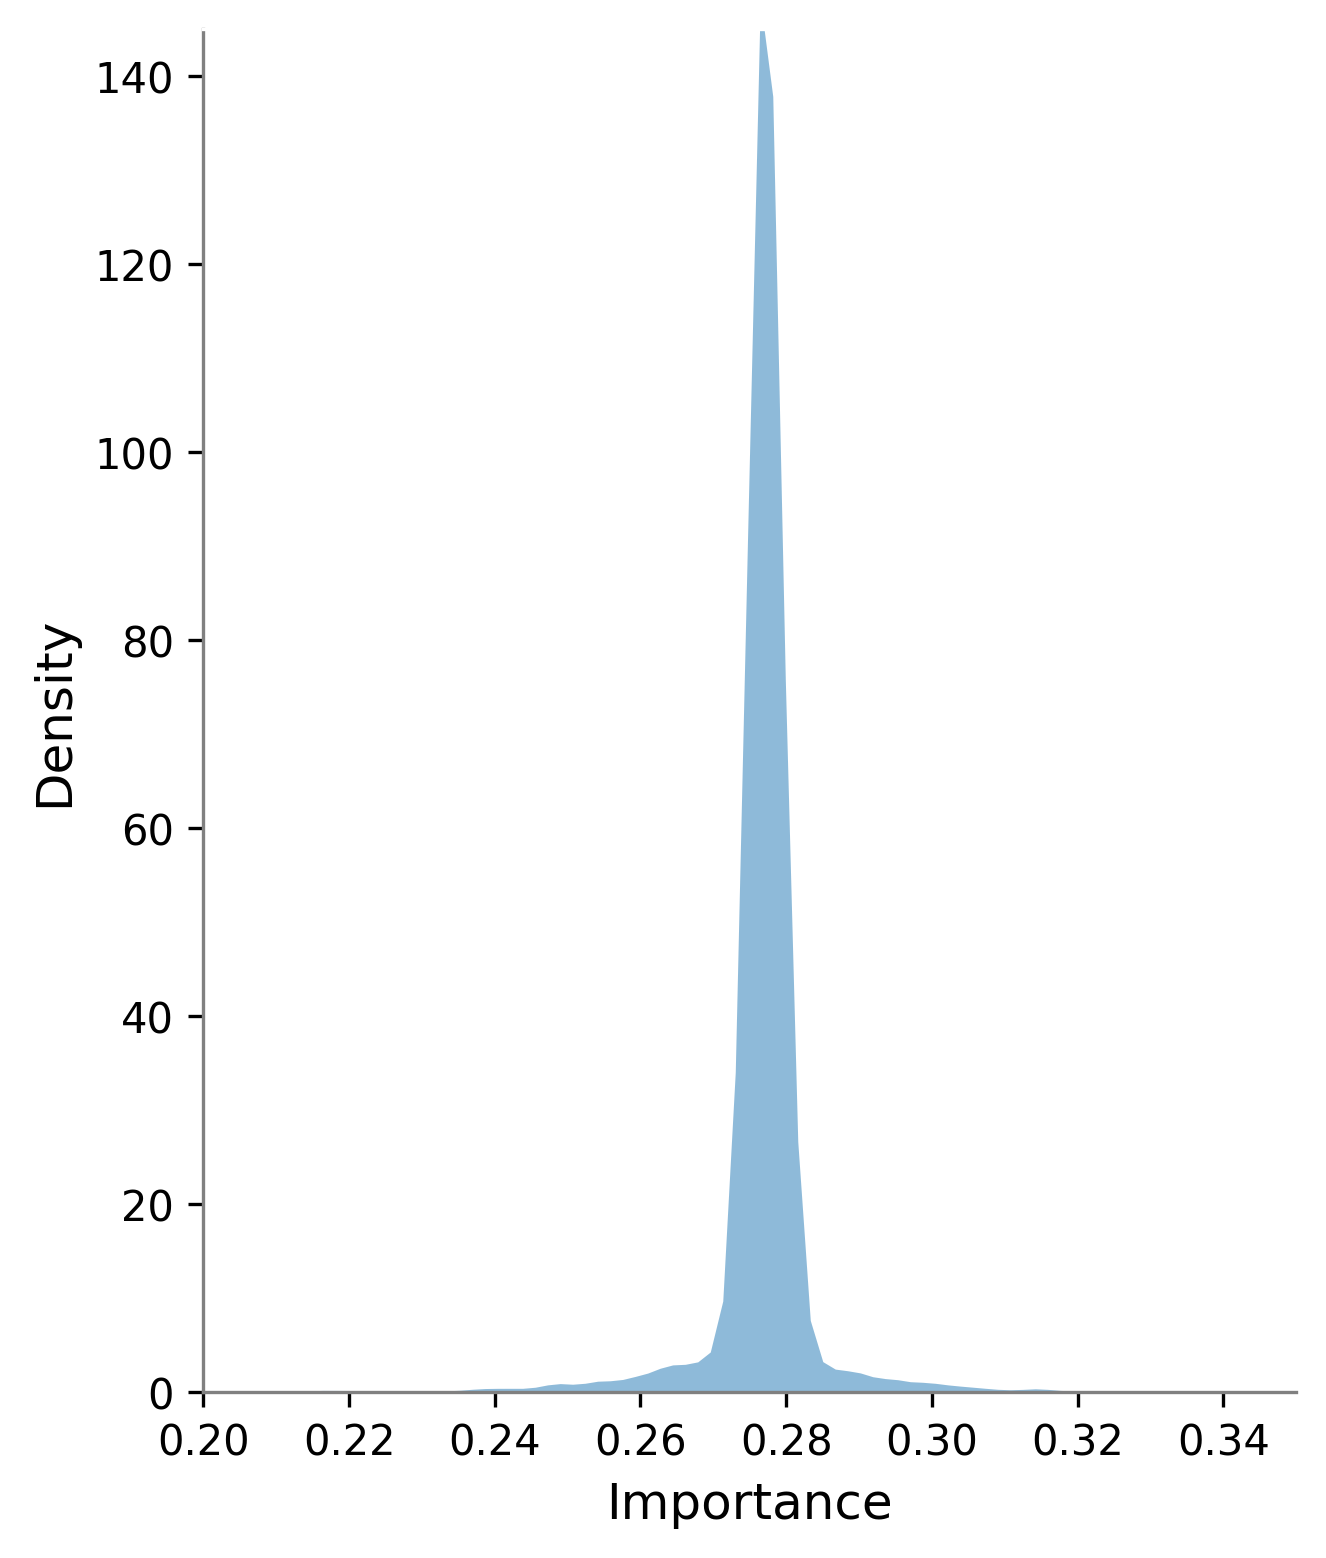

In [61]:
from matplotlib.patches import Patch

# plt.figure(figsize=(8, 6))
# plt.figure(figsize=(4.7, 5.9))

# data = edge_importance_df
data = edge_importance_df.sort_values(by='Importance', ascending=False)

# Define custom legend handles
legend_elements = [
    # Patch(facecolor='mediumseagreen', edgecolor='none', label='S', alpha= 0.5),
    Patch(facecolor='indianred', edgecolor='none', alpha= 0.5)
]

# Create plot (or not—this works standalone)
fig, ax = plt.subplots(figsize=(4.7, 5.9))

# sns.kdeplot(full_set_df[full_set_df['phenotype_label'] == 'S']['RMSD'], color='mediumseagreen', label='S')
# sns.kdeplot(full_set_df[full_set_df['phenotype_label'] == 'R']['RMSD'], color='indianred', label='R')
sns.kdeplot(data, x=edge_importance_df['Importance'], 
            # multiple='stack', 
            # hue='Phenotype',
            # palette={'S': 'mediumseagreen', 'R': 'indianred'},
            fill=True,
            common_norm=True,
            linewidth=0,
            alpha=0.5
            )

# Change figure outline color
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

plt.xlim(0.2, 0.35)
plt.ylim(0, 145)

plt.show()

In [62]:
edge_weight_dict = defaultdict(list)

for graph in test_list:
    for edge, weight in zip(graph.edge_index.t(), graph.edge_attr):
        edge = tuple(edge.tolist()) 
        edge_weight_dict[edge].append(weight.item())


In [63]:
avg_edge_weight = {edge: np.mean(weights) for edge, weights in edge_weight_dict.items()}

In [64]:
edge_weight_df = pd.DataFrame(list(avg_edge_weight.items()), columns=['Edge', 'Weight'])

In [65]:
edge_weight_df.to_csv('../data/edge_weight_df.csv', index=False)

In [66]:
edge_weight_df.sort_values(by='Weight', ascending=False).describe()

,Weight
count,6.256000e+03
mean,9.698959e-03
std,4.584617e-02
min,0.000000e+00
25%,1.947621e-07
50%,3.361166e-06
75%,3.954227e-04
max,9.288905e-01


In [67]:
edge_weight_df

,Edge,Weight
0,"(0, 1)",7.448223e-05
1,"(0, 2)",7.500190e-04
2,"(0, 39)",4.846348e-06
3,"(0, 40)",1.965541e-06
4,"(0, 41)",9.288905e-01
...,...,...
6251,"(53, 107)",1.256869e-07
6252,"(56, 107)",2.572807e-08
6253,"(107, 51)",1.014563e-07
6254,"(107, 53)",1.256869e-07


In [68]:
matrix = pd.DataFrame(
    0, 
    index=sorted(set([e[1] for e in edge_weight_df['Edge']])), 
    columns=sorted(set([e[0] for e in edge_weight_df['Edge']]))
)
for idx, row in edge_weight_df.iterrows():
    x, y = row['Edge']
    matrix.at[y, x] = np.log(row['Weight'] + 1e-8)

matrix = matrix.replace(0, -100)

/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_49863/749001694.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-9.504815682134879' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix.at[y, x] = np.log(row['Weight'] + 1e-8)
/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_49863/749001694.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-9.504815682134879' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix.at[y, x] = np.log(row['Weight'] + 1e-8)
/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_49863/749001694.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-7.195398633169848' has dtype incompatible with int64, ple

In [69]:
matrix

,0,1,2,3,4,5,6,7,8,9,...,175,176,177,178,179,180,181,182,183,184
0,-100.000000,-9.504816,-7.195399,-16.659276,-100.000000,-100.000000,-100.000000,-100.00000,-100.000000,-100.0,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
1,-9.504816,-100.000000,-6.151653,-10.416600,-14.584657,-100.000000,-100.000000,-100.00000,-100.000000,-100.0,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-12.678753,-100.000000,-14.166549,-100.000000,-100.000000
2,-7.195399,-6.151653,-100.000000,-5.157637,-5.915444,-13.441364,-16.517533,-100.00000,-100.000000,-100.0,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
3,-16.659276,-10.416600,-5.157637,-100.000000,-5.252576,-4.189587,-12.279064,-100.00000,-15.934606,-100.0,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-16.472796,-100.000000,-13.902138
4,-100.000000,-14.584657,-5.915444,-5.252576,-100.000000,-6.548030,-5.841564,-13.23722,-16.749338,-100.0,...,-100.000000,-100.000000,-100.000000,-100.000000,-18.412653,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,-100.000000,-12.678753,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.00000,-100.000000,-100.0,...,-10.472849,-100.000000,-16.967392,-11.209299,-7.603549,-100.000000,-7.033707,-3.164943,-14.368255,-16.706666
181,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.00000,-100.000000,-100.0,...,-1.818073,-14.055679,-12.902366,-13.353681,-4.931509,-7.033707,-100.000000,-5.700989,-10.233407,-16.466142
182,-100.000000,-14.166549,-100.000000,-16.472796,-100.000000,-100.000000,-100.000000,-100.00000,-100.000000,-100.0,...,-11.993289,-100.000000,-100.000000,-100.000000,-11.889208,-3.164943,-5.700989,-100.000000,-4.738538,-8.458644
183,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.00000,-100.000000,-100.0,...,-15.364983,-100.000000,-100.000000,-100.000000,-100.000000,-14.368255,-10.233407,-4.738538,-100.000000,-4.582539


In [70]:
pd.DataFrame(matrix[matrix > -100].values.flatten()).describe()

,0
count,6256.000000
mean,-11.566775
std,4.683652
min,-18.420681
25%,-15.401417
50%,-12.600255
75%,-7.835530
max,-0.073764


/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_49863/1287445766.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrBr').copy()


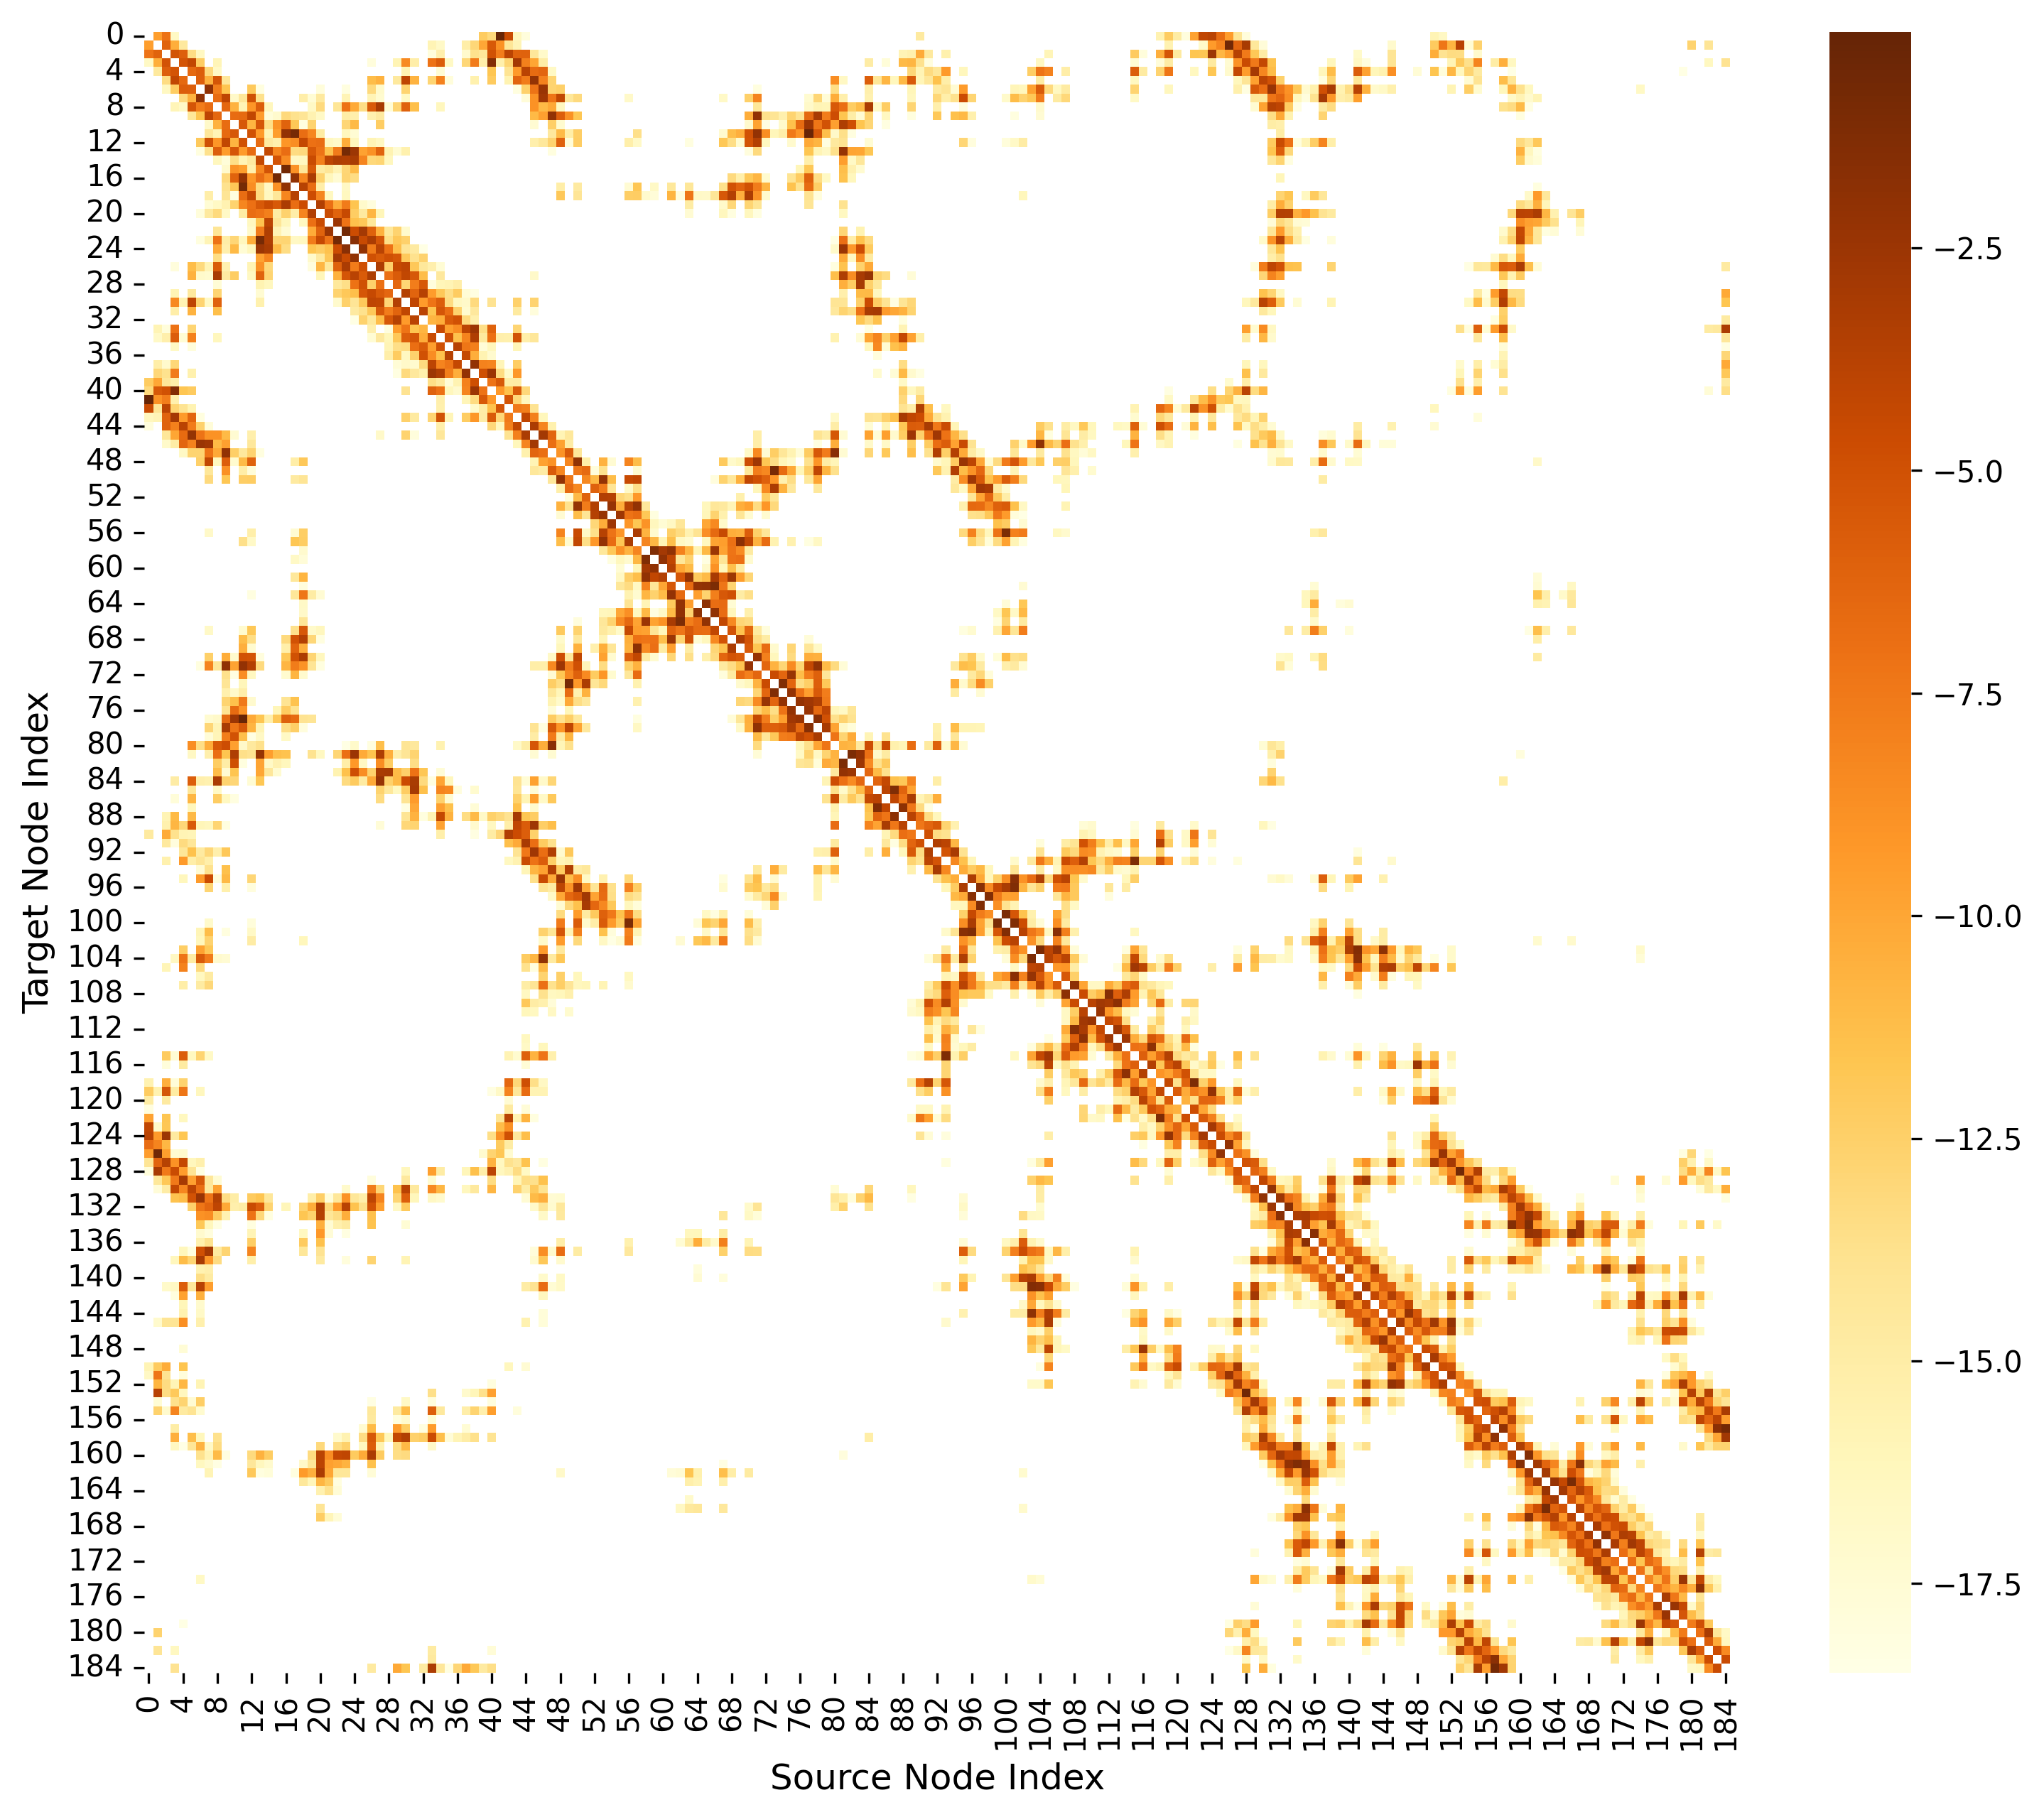

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume matrix is a NumPy array or DataFrame
matrix_plot = matrix.copy()

# Replace -100 with NaN for special color treatment
matrix_plot = np.where(matrix_plot == -100, np.nan, matrix_plot)

# Get the colormap and set NaNs (bad values) to white
cmap = plt.cm.get_cmap('YlOrBr').copy()
cmap.set_bad(color='white')

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(matrix_plot, cmap=cmap, 
            vmin=-18.5,
            vmax=-0.07)

plt.xlabel('Source Node Index')
plt.ylabel('Target Node Index')
plt.show()



### Nodes

In [13]:
# Print the feature importance
print("Node feature importance:")
print(node_feature_masks[6])

Node feature importance:
tensor([0.2908, 0.2795, 0.2784, 0.2746, 0.2643, 0.3200, 0.2830, 0.2562, 0.2972,
        0.2845, 0.2839, 0.2549, 0.3123, 0.3074, 0.2603, 0.7011, 0.2415, 0.2611])


In [17]:
avg_node_mask = node_feature_masks.mean(dim=0).unsqueeze(0)
# avg_edge_mask = edge_masks.mean(dim=0).unsqueeze(0)

In [18]:
mean_per_feature = node_feature_masks.mean(dim=0)
std_per_feature = node_feature_masks.std(dim=0)

print("Mean per feature:", mean_per_feature)
print("Std per feature:", std_per_feature)

Mean per feature: tensor([0.2695, 0.2726, 0.2713, 0.2763, 0.2637, 0.2766, 0.2726, 0.2733, 0.3070,
        0.2829, 0.2902, 0.2738, 0.2733, 0.2955, 0.2742, 0.7056, 0.2807, 0.2752])
Std per feature: tensor([0.0198, 0.0180, 0.0183, 0.0185, 0.0179, 0.0178, 0.0181, 0.0194, 0.0379,
        0.0200, 0.0175, 0.0176, 0.0197, 0.0213, 0.0181, 0.0195, 0.0188, 0.0195])


In [19]:
avg_node_mask[0]

tensor([0.2695, 0.2726, 0.2713, 0.2763, 0.2637, 0.2766, 0.2726, 0.2733, 0.3070,
        0.2829, 0.2902, 0.2738, 0.2733, 0.2955, 0.2742, 0.7056, 0.2807, 0.2752])

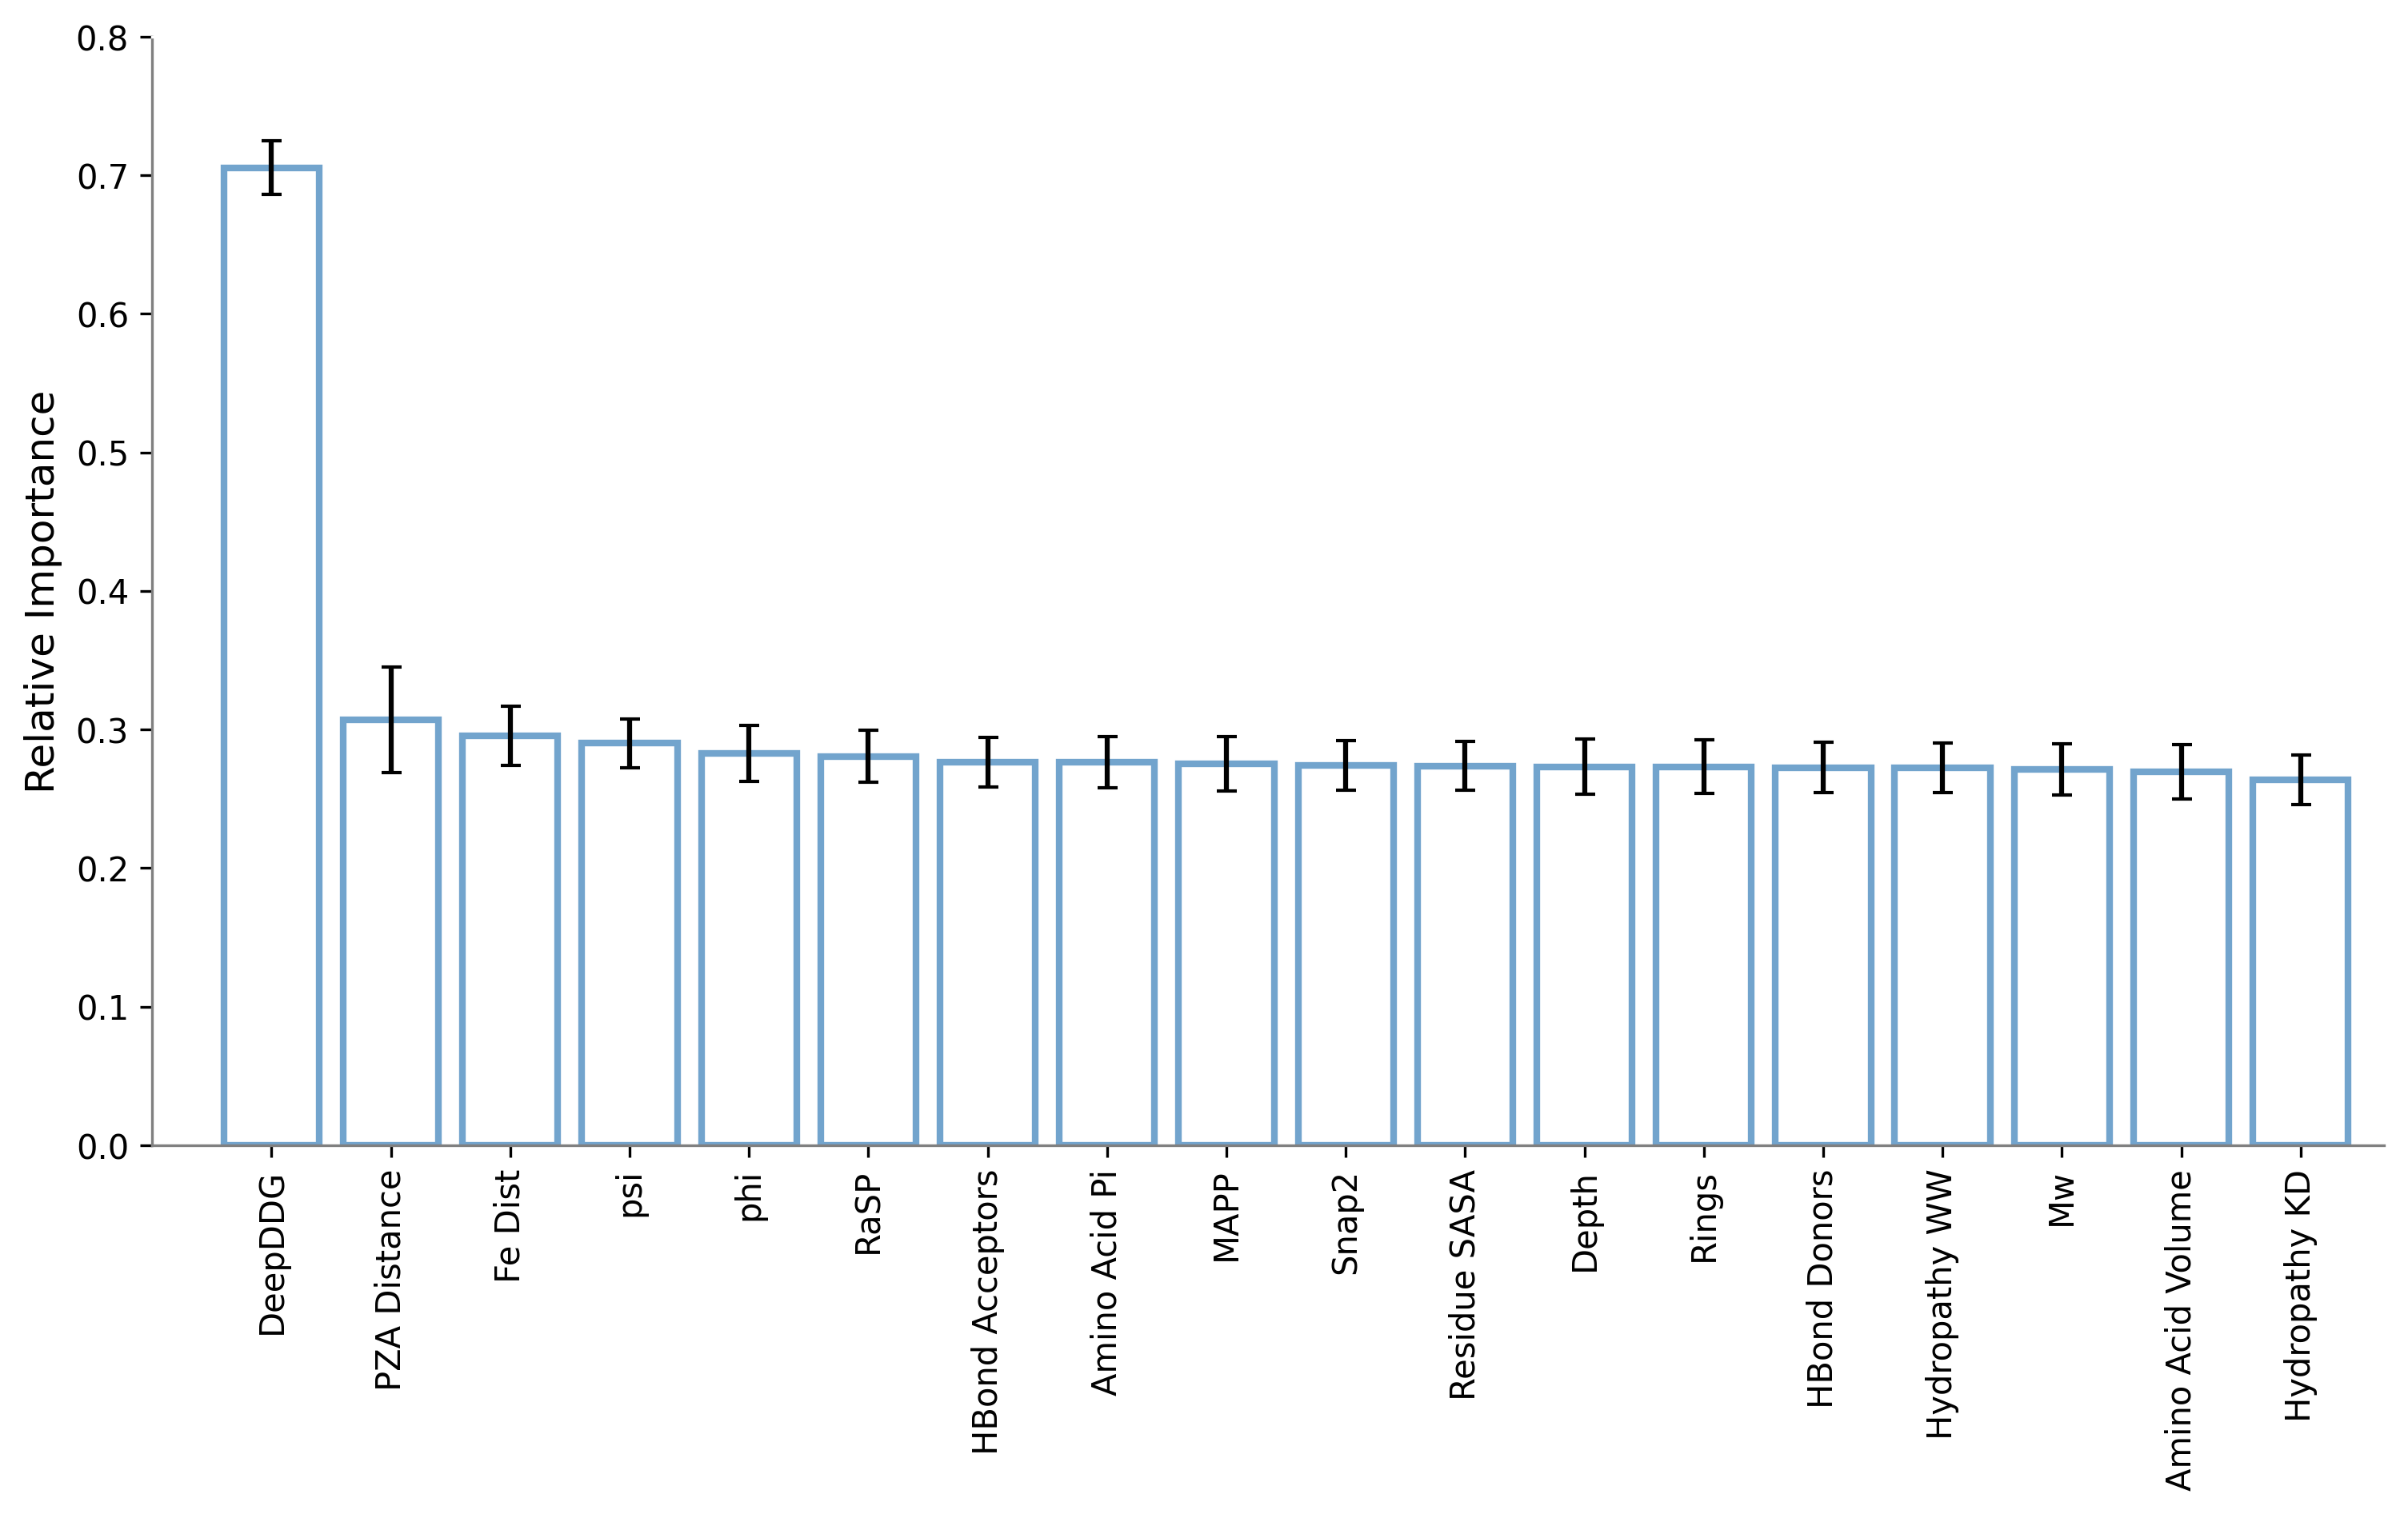

In [76]:
plt.figure(figsize=(12, 6))

# Get sorted indices for ascending order
sorted_indices = avg_node_mask[0].argsort(descending=True)
labels = [
    'Amino Acid Volume', 
    'Hydropathy WW', 
    'Mw', 
    'Amino Acid Pi', 
    'Hydropathy KD', 
    'HBond Acceptors', 
    'HBond Donors', 
    'Rings', 
    'PZA Distance',
    'phi',
    'psi',
    'Residue SASA',
    'Depth',
    'Fe Dist',
    'Snap2',
    'DeepDDG',
    'RaSP',
    'MAPP'
    ]
# Sort values and labels
sorted_values = avg_node_mask[0][sorted_indices]
sorted_labels = [labels[i] for i in sorted_indices]
plt.errorbar(
    range(len(sorted_values)),
    sorted_values,
    yerr=std_per_feature[sorted_indices],
    fmt='none',
    ecolor='black',
    elinewidth=1.5,
    capsize=3
)
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

plt.xlim(-1, len(sorted_values) - 0.3)
plt.bar(range(len(sorted_values)), sorted_values, 
        alpha=0.7,
        color='white', 
        edgecolor='#377eb8',
        linewidth=2)
plt.ylabel("Relative Importance")
plt.ylim(0, 0.8)
plt.yticks(np.arange(0, 0.9, 0.1))
plt.xticks(range(len(sorted_labels)), sorted_labels, rotation=90)
plt.show()


In [74]:
avg_node_mask

tensor([[0.2695, 0.2726, 0.2713, 0.2763, 0.2637, 0.2766, 0.2726, 0.2733, 0.3070,
         0.2829, 0.2902, 0.2738, 0.2733, 0.2955, 0.2742, 0.7056, 0.2807, 0.2752]])